In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
from PIL import Image, ImageOps

# Домашнее задание

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
1) Выведите кол-во обучаемых параметров сети;    
2) Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.    
3) Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
3) Выведите confusion matrix для тестовой подвыборки;    

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

2024-10-03 14:08:19.238897: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 14:08:19.330797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 14:08:19.412356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 14:08:19.436170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 14:08:19.576885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

In [12]:
data_path ="/home/ubuntu/Downloads/data_CNN/indoor_outdoor_dataset"

transform = transforms.Compose([
    transforms.Resize((64, 64)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
])

full_data = ImageFolder(data_path, transform=transform)

# train_size = int(0.1 * len(full_data))
# val_size = int(0.0125 * len(full_data))
# test_size = len(full_data) - train_size - val_size

# train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])

train_size = int(0.8*len(full_data))
val_size = int(0.1*len(full_data)) 
test_size = int(0.1*len(full_data)) 
oth=len(full_data)-train_size-test_size-val_size 
train_data, val_data, test_data,_ = random_split(full_data, [train_size, val_size, test_size, oth])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [31]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # 32*126*126
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 32*63*63
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.fc_layers = nn.Sequential(
#             nn.Linear(128 * 16 * 16, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc_layers(x)
#         return x


### Обучим на небольшом наборе данных простенькую нейросеть

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*8*8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [3]:
print(torch.cuda.is_available())

False


In [23]:
model = ConvNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, plot=True):
    best_val_acc = 0.0
    train_loss_epochs = []
    val_loss_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs = []
    try:
        for epoch in tqdm(range(num_epochs)):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                optimizer.zero_grad()        
                outputs = model(inputs)
                loss = criterion(outputs, labels)      
                loss.backward()
                optimizer.step()           
                running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            val_loss, val_acc = evaluate_model(model, val_loader, criterion)

            train_loss_epochs.append(train_loss)
            train_accuracy_epochs.append(train_acc)
            val_loss_epochs.append(val_loss)
            val_accuracy_epochs.append(val_acc)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            
    
            if val_acc > best_val_acc:
                print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
                best_val_acc = val_acc
                

        if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(val_loss_epochs, label='Val')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(val_accuracy_epochs, label='Val accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss, \
           val_loss, \
           train_acc, \
           val_acc
            
    
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    print("accuracy=",accuracy)
    return loss, accuracy

In [25]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

  5%|██▏                                        | 1/20 [02:24<45:47, 144.60s/it]

Epoch [1/20], Loss: 0.4493, Accuracy: 0.7942, Val Loss: 0.3915, Val Accuracy: 0.8287


 10%|████▎                                      | 2/20 [04:37<41:20, 137.83s/it]

Epoch [2/20], Loss: 0.3717, Accuracy: 0.8397, Val Loss: 0.3675, Val Accuracy: 0.8460


 15%|██████▍                                    | 3/20 [06:46<37:56, 133.92s/it]

Epoch [3/20], Loss: 0.3310, Accuracy: 0.8622, Val Loss: 0.3278, Val Accuracy: 0.8590


 20%|████████▌                                  | 4/20 [08:56<35:17, 132.37s/it]

Epoch [4/20], Loss: 0.3048, Accuracy: 0.8740, Val Loss: 0.3309, Val Accuracy: 0.8573


 25%|██████████▊                                | 5/20 [11:06<32:51, 131.42s/it]

Epoch [5/20], Loss: 0.2792, Accuracy: 0.8851, Val Loss: 0.3090, Val Accuracy: 0.8667


 30%|████████████▉                              | 6/20 [13:18<30:42, 131.59s/it]

Epoch [6/20], Loss: 0.2589, Accuracy: 0.8947, Val Loss: 0.3102, Val Accuracy: 0.8737


 35%|███████████████                            | 7/20 [15:29<28:27, 131.38s/it]

Epoch [7/20], Loss: 0.2272, Accuracy: 0.9089, Val Loss: 0.3448, Val Accuracy: 0.8653


 40%|█████████████████▏                         | 8/20 [17:40<26:16, 131.39s/it]

Epoch [8/20], Loss: 0.1972, Accuracy: 0.9210, Val Loss: 0.3440, Val Accuracy: 0.8497


 45%|███████████████████▎                       | 9/20 [19:53<24:09, 131.75s/it]

Epoch [9/20], Loss: 0.1620, Accuracy: 0.9363, Val Loss: 0.3603, Val Accuracy: 0.8603


 50%|█████████████████████                     | 10/20 [22:18<22:38, 135.82s/it]

Epoch [10/20], Loss: 0.1212, Accuracy: 0.9537, Val Loss: 0.3965, Val Accuracy: 0.8657


 55%|███████████████████████                   | 11/20 [24:37<20:30, 136.69s/it]

Epoch [11/20], Loss: 0.0936, Accuracy: 0.9659, Val Loss: 0.5151, Val Accuracy: 0.8510


 60%|█████████████████████████▏                | 12/20 [27:00<18:28, 138.58s/it]

Epoch [12/20], Loss: 0.0643, Accuracy: 0.9761, Val Loss: 0.5509, Val Accuracy: 0.8487


 65%|███████████████████████████▎              | 13/20 [29:17<16:08, 138.39s/it]

Epoch [13/20], Loss: 0.0491, Accuracy: 0.9823, Val Loss: 0.5676, Val Accuracy: 0.8570


 70%|█████████████████████████████▍            | 14/20 [31:37<13:51, 138.65s/it]

Epoch [14/20], Loss: 0.0357, Accuracy: 0.9879, Val Loss: 0.6739, Val Accuracy: 0.8540


 70%|█████████████████████████████▍            | 14/20 [31:38<13:33, 135.58s/it]


KeyboardInterrupt: 

### До конца дообучать не стал так как видно что переобучается модель, нужно применить регуляризацию

### Добавим BatchNorm и заупстим на полном датасете

 10%|███████▉                                                                       | 1/10 [20:08<3:01:17, 1208.63s/it]

Epoch [1/10], Loss: 0.3234, Accuracy: 0.8649, Val Loss: 0.3239, Val Accuracy: 0.8653
Validation accuracy improved from 0.0000 to 0.8653. Saving model...


 20%|███████████████▊                                                               | 2/10 [39:48<2:38:51, 1191.44s/it]

Epoch [2/10], Loss: 0.2517, Accuracy: 0.8998, Val Loss: 0.2472, Val Accuracy: 0.9026
Validation accuracy improved from 0.8653 to 0.9026. Saving model...


 30%|███████████████████████▋                                                       | 3/10 [59:17<2:17:50, 1181.48s/it]

Epoch [3/10], Loss: 0.2268, Accuracy: 0.9112, Val Loss: 0.2274, Val Accuracy: 0.9116
Validation accuracy improved from 0.9026 to 0.9116. Saving model...


 40%|██████████████████████████████▊                                              | 4/10 [1:18:56<1:58:01, 1180.31s/it]

Epoch [4/10], Loss: 0.2102, Accuracy: 0.9181, Val Loss: 0.2350, Val Accuracy: 0.9085


 50%|██████████████████████████████████████▌                                      | 5/10 [1:38:37<1:38:23, 1180.72s/it]

Epoch [5/10], Loss: 0.1951, Accuracy: 0.9243, Val Loss: 0.2289, Val Accuracy: 0.9097


 60%|██████████████████████████████████████████████▏                              | 6/10 [1:58:08<1:18:28, 1177.22s/it]

Epoch [6/10], Loss: 0.1815, Accuracy: 0.9295, Val Loss: 0.2366, Val Accuracy: 0.9115


 70%|███████████████████████████████████████████████████████▎                       | 7/10 [2:17:51<58:58, 1179.34s/it]

Epoch [7/10], Loss: 0.1684, Accuracy: 0.9346, Val Loss: 0.2455, Val Accuracy: 0.9053


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [2:37:24<39:14, 1177.33s/it]

Epoch [8/10], Loss: 0.1568, Accuracy: 0.9393, Val Loss: 0.2605, Val Accuracy: 0.9075


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [2:57:02<19:37, 1177.39s/it]

Epoch [9/10], Loss: 0.1457, Accuracy: 0.9433, Val Loss: 0.2644, Val Accuracy: 0.9041


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [3:16:39<00:00, 1179.97s/it]

Epoch [10/10], Loss: 0.1349, Accuracy: 0.9463, Val Loss: 0.2760, Val Accuracy: 0.9050


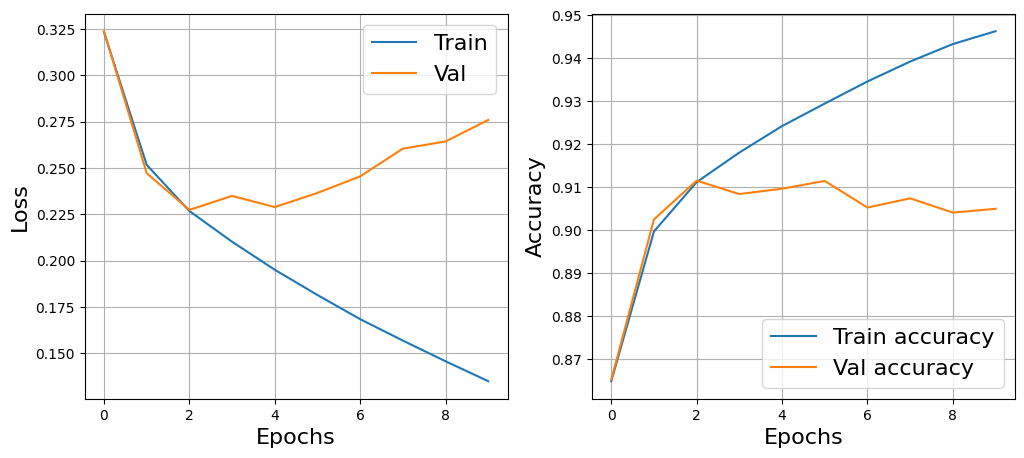

(0.13491727939653714,
 0.2759871211459982,
 0.9463063951842007,
 0.9050228977881711)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet_BN(nn.Module):
    def __init__(self):
        super(ConvNet_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        x = F.relu(self.bn3(F.max_pool2d(self.conv3(x), 2)))
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


    
model = ConvNet_BN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

### Здесь выведем кол-во обучаемых параметров нашей сети

In [7]:

net = ConvNet_BN()

# Выведите количество обучаемых параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {count_parameters(net)}")

Количество обучаемых параметров: 1142529


### Посмотрим качество на тесте ( получили 0.91 - accuracy )

In [16]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy
evaluate_model(model,test_loader,criterion)

(0.2577637351840456, 0.9101140017538731)

### Здесь реализация немного другой архитектуры по подобию MobileNet ( не точная копия )
### По итогу обучение очень долгое ( 17 часов ) и предварительно закончил
### Кол-во параметров слишком большое ~25 млн, но результат по первым 3 эпохам не супер 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(2048)
        self.relu7 = nn.ReLU()
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu8 = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.relu6(self.bn6(self.conv6(x)))
        x = self.relu7(self.bn7(self.conv7(x)))
        x = x.view(-1, 2048)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.relu8(x)
        return x
net = MobileNet()

# Выведите количество обучаемых параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {count_parameters(net)}")

Количество обучаемых параметров: 25435137


In [18]:
model = MobileNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

 10%|███████▌                                                                    | 1/10 [1:53:02<16:57:23, 6782.58s/it]

Epoch [1/10], Loss: 0.3578, Accuracy: 0.8465, Val Loss: 0.2963, Val Accuracy: 0.8762
Validation accuracy improved from 0.0000 to 0.8762. Saving model...


 20%|███████████████▏                                                            | 2/10 [3:46:02<15:04:09, 6781.15s/it]

Epoch [2/10], Loss: 0.2874, Accuracy: 0.8828, Val Loss: 0.2676, Val Accuracy: 0.8930
Validation accuracy improved from 0.8762 to 0.8930. Saving model...


 30%|██████████████████████▊                                                     | 3/10 [5:39:22<13:12:08, 6789.75s/it]

Epoch [3/10], Loss: 0.2561, Accuracy: 0.8971, Val Loss: 0.2546, Val Accuracy: 0.8972
Validation accuracy improved from 0.8930 to 0.8972. Saving model...


 30%|██████████████████████▊                                                     | 3/10 [5:49:38<13:35:50, 6992.94s/it]


(0.25612357263587593,
 0.2545567108579328,
 0.8970735554276701,
 0.8972035467212316)